# KIT Object detection

## Data overview

In [ ]:
# Pip install packages not available on your computer

In [99]:
import os
import pandas as pd
import numpy as np

import torch
import torchvision
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from skimage import io, transform

import cv2
import matplotlib.pyplot as plt

In [15]:
# CHANGE THESE IF YOU WANT TO RUN THE CODE

path_to_training_dir = 'C:\\Users\\DELL\\Desktop\\KIT object detection\\data_object_image_2\\training\\image_2'
path_to_testing_dir = 'C:\\Users\\DELL\\Desktop\\KIT object detection\\data_object_image_2\\testing\\image_2'  # Probably unable to use
path_to_labels_dir = 'C:\\Users\\DELL\\Desktop\\KIT object detection\\data_object_label_2\\training\label_2'

Shape of image0: (375, 1242, 3)
	Height:		 375
	Width:		 1242
	Channel:	 3



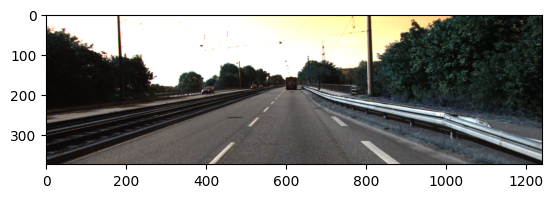

In [44]:
image0 = cv2.imread(f'{path_to_training_dir}\\000001.png', cv2.IMREAD_UNCHANGED)

print(f'Shape of image0: {image0.shape}')
print(f'\tHeight:\t\t {image0.shape[0]}') 
print(f'\tWidth:\t\t {image0.shape[1]}') 
print(f'\tChannel:\t {image0.shape[2]}') # RGB
print()

cv2.imshow('Image0', image0)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Or another method to display picture
plt.imshow(image0)
plt.show()

> Important note

Neccessary to understand annotation files and parse them into an adequate form

In [16]:
# Understanding the labels
with open(os.path.join(path_to_labels_dir, '000000.txt'), 'r') as label_file:
    content = label_file.read()
    print(f'Content of label file:\n\n{content}')

Content of label file:

Pedestrian 0.00 0 -0.20 712.40 143.00 810.73 307.92 1.89 0.48 1.20 1.84 1.47 8.41 0.01



So the format of the label file is as follows:

*\[object_type\] \[truncation_level\] \[occlusion\] \[alpha\] \[left\] \[top\] \[right\] \[bottom\] \[height\] \[width\] \[length\] \[x\] \[y\] \[z\] \[rotation_y\]*


**Meanings:** 
<ol>
    <li>object_type: The type of the annotated object.</li>
    <ul>
        <li>Car</li>
        <li>Van</li>
        <li>Truck</li>
        <li>Pedestrian</li>
        <li>Person_sitting</li>
        <li>Cyclist</li>
        <li>Tram</li>
        <li>Misc</li>
        <li>DontCare: It is used for objects that are present but ignored for evaluation</li>
    </ul>
    <li>truncation_level: The fraction of the object that is visible. Float. Range: [0.0, 1.0] 0.0 means fully visible.</li>
    <li>occlusion: The level of occlusion of the object. Intiger. 0 means fully visible</li> 
    <li>alpha: The observation angle of the object in radians relative to the camera. </li>
    <li>left, top, right, bottom: The 2D bounding box coordinates of the object in the image. They represent the pixel locations of the top-left and bottom-right corners of the bounding box</li>
    <li>height, width, length: The 3D dimensions of the object (height, width, and length) in meters</li>
    <li>x, y, z: The 3D location of the object's centroid in the camera coordinate system (in meters)</li>
    <li>rotation_y: The rotation of the object around the y-axis in camera coordinates, in radians</li>
</ol>

**Description:**
Each line in the label file corresponds to a single object annotation in the image. Multiple objects in the image are represented by multiple lines in the label file.



*source:* [https://medium.com/@abdulhaq.ah/explain-label-file-of-kitti-dataset-738528de36f4]

In [183]:
img_class_encoder = {
    'Car': 0,
    'Van': 1,
    'Truck': 2,
    'Pedestrian': 3, 
    'Person_sitting': 4,
    'Cyclist': 5,
    'Tram': 6,
    'Misc': 7,
    'DontCare': 8
}

In [184]:
# Converting the label file into dictionary format

def convertLabelFileToListOfDicts(path_to_labels_dir, idx):
    try:
        with open(os.path.join(path_to_labels_dir, '{:06d}'.format(idx) + '.txt'), 'r') as label_file:
            content = []
            for line in label_file.readlines():
                object_dict = convertObjectLineToDict(line)
                content.append(object_dict)

            return content

    except FileNotFoundError as e:
        print(f"Cannot find file: {e}")
    else:
        print("File handling problem, but file has been found!")


def convertObjectLineToDict(line):
    line_elements = line.split()
    object_dict = {
        'object_type': line_elements[0],
        'truncation_level': line_elements[1],
        'occlusion': line_elements[2],
        'alpha': line_elements[3],
        'left': line_elements[4],
        'top':  line_elements[5],
        'right': line_elements[6], 
        'bottom': line_elements[7],
        'height': line_elements[8],
        'width': line_elements[9],
        'length': line_elements[10],
        'x': line_elements[11],
        'y': line_elements[12],
        'z': line_elements[13],
        'rotation_y': line_elements[14]
    }

    return object_dict

In [185]:
content = convertLabelFileToListOfDicts(path_to_labels_dir, 1)
display(content)


[{'object_type': 'Truck',
  'truncation_level': '0.00',
  'occlusion': '0',
  'alpha': '-1.57',
  'left': '599.41',
  'top': '156.40',
  'right': '629.75',
  'bottom': '189.25',
  'height': '2.85',
  'width': '2.63',
  'length': '12.34',
  'x': '0.47',
  'y': '1.49',
  'z': '69.44',
  'rotation_y': '-1.56'},
 {'object_type': 'Car',
  'truncation_level': '0.00',
  'occlusion': '0',
  'alpha': '1.85',
  'left': '387.63',
  'top': '181.54',
  'right': '423.81',
  'bottom': '203.12',
  'height': '1.67',
  'width': '1.87',
  'length': '3.69',
  'x': '-16.53',
  'y': '2.39',
  'z': '58.49',
  'rotation_y': '1.57'},
 {'object_type': 'Cyclist',
  'truncation_level': '0.00',
  'occlusion': '3',
  'alpha': '-1.65',
  'left': '676.60',
  'top': '163.95',
  'right': '688.98',
  'bottom': '193.93',
  'height': '1.86',
  'width': '0.60',
  'length': '2.02',
  'x': '4.59',
  'y': '1.32',
  'z': '45.84',
  'rotation_y': '-1.55'},
 {'object_type': 'DontCare',
  'truncation_level': '-1',
  'occlusion': 

In [186]:
# Check what are the different picture shapes (Why aren't they equal?)
from PIL import Image
shape_dict = {}

for idx in range(len(os.listdir(path_to_training_dir))):
    with Image.open(os.path.join(path_to_training_dir, '{:06d}'.format(idx) + '.png')) as img:
        shape_dict[img.size] = shape_dict.get(img.size, 0) + 1

print(shape_dict)

{(1224, 370): 770, (1242, 375): 6057, (1238, 374): 358, (1241, 376): 296}


In [187]:
# Since the pictures are not the same size we should rescale them
# We will need to give tuples as params since an int param keeps the ratio, the resulting pictures will still have different shapes

class Rescale(object):
    """
    Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size.
          If tuple, output is matched to output_size. 
          Removed this functionality --> If int, smaller of image edges is matched to output_size keeping aspect ratio the same.
    
    """

    def __init__(self, output_size):
        # Checks if the input is indeed a tuple and then assigns it to output_size
        assert isinstance(output_size, tuple)
        self.output_size = output_size

    def __call__(self, sample):
        image = sample
        h, w = image.shape[1:]
        new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)

        image.resize_(new_h, new_w)

        return image

In [223]:
class TransformLabels():
   
   def __call__(self, labels):
      tensor_labels = [torch.tensor([img_class_encoder.get(bbox['object_type']), float(bbox['truncation_level']), int(bbox['occlusion']), float(bbox['alpha']), float(bbox['left']), float(bbox['top']),
                                      float(bbox['right']), float(bbox['bottom']), float(bbox['height']), float(bbox['width']), float(bbox['length']), float(bbox['x']),
                                      float(bbox['y']), float(bbox['z']), float(bbox['rotation_y'])]) for bbox in labels]
      
      padded_labels = pad_sequence(tensor_labels, batch_first=True, padding_value=-1)

      return padded_labels

As it can be seen there are only a few number of shapes, so cropping it to a (min{width}, min{height}) might be an option as well. 

In [189]:
# Cropping transformation

class Crop(object):
    """
    Crop the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop is made.
    """

    def __init__(self, output_size):
        # Checks if the input is indeed a tuple and then assigns it to output_size
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            # In case of int, a square picture is cropped --> might not use it yet
            self.output_size = (output_size, output_size)
        else:
            # In case of tuple
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image = sample

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        #top = np.random.randint(0, h - new_h + 1)
        #left = np.random.randint(0, w - new_w + 1)

        image = image[0: new_h, 0: new_w]

        return image


In [222]:
content = convertLabelFileToListOfDicts(path_to_labels_dir, 0)
#display(content)

transform = TransformLabels()
transformed_label = transform(content)
display(transformed_label)

tensor([[ 3.0000e+00,  0.0000e+00,  0.0000e+00, -2.0000e-01,  7.1240e+02,
          1.4300e+02,  8.1073e+02,  3.0792e+02,  1.8900e+00,  4.8000e-01,
          1.2000e+00,  1.8400e+00,  1.4700e+00,  8.4100e+00,  1.0000e-02]])

In [217]:
# Creating a custom dataset for my files

class ImageDataset(Dataset):
    # Initializes dataset
    def __init__(self, annotations_dir, img_dir, transform=None, target_transform=None):
        self.img_labels_dir = annotations_dir
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    # Returns the number of files in the dataset
    def __len__(self):
        return len(os.listdir(self.img_labels_dir))


    def __getitem__(self, idx):
        # Getting the image
        print('Trying to get an item!')
        img_path = os.path.join(path_to_training_dir, '{:06d}'.format(idx) + '.png')
        image = torchvision.io.read_image(img_path)

        # Getting the labels (format: list of dictionaries)
        label = convertLabelFileToListOfDicts(path_to_labels_dir, idx)
        
        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)

        return image, label




In [224]:
training_data = ImageDataset(annotations_dir=path_to_labels_dir, img_dir=path_to_training_dir, transform=Rescale((370,1224)),target_transform=TransformLabels())
train_dataloader = DataLoader(training_data, batch_size=2, shuffle=False)

In [48]:
# Iterate through all the images in the Dataloader


In [219]:
img, label = training_data.__getitem__(0)
print(type(img))
print(img.shape)
print(type(label))
print(len(label))
print(label)

Trying to get an item!
<class 'torch.Tensor'>
torch.Size([370, 1224])
<class 'torch.Tensor'>
15
tensor([[ 3.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [-2.0000e-01],
        [ 7.1240e+02],
        [ 1.4300e+02],
        [ 8.1073e+02],
        [ 3.0792e+02],
        [ 1.8900e+00],
        [ 4.8000e-01],
        [ 1.2000e+00],
        [ 1.8400e+00],
        [ 1.4700e+00],
        [ 8.4100e+00],
        [ 1.0000e-02]])


In [225]:
for i, (train_features, train_labels) in enumerate(train_dataloader):
    print(f"Batch {i+1}: Features size: {train_features.size()}, Labels size: {len(train_labels)}")

Trying to get an item!
Trying to get an item!


RuntimeError: stack expects each tensor to be equal size, but got [1, 15] at entry 0 and [7, 15] at entry 1

In [72]:
train_features, train_labels = next(iter(train_dataloader))


print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {len(train_labels)}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

Trying to get an item!
FASZAA
image_shape: torch.Size([370, 1224])
Trying to get an item!
FASZAA
image_shape: torch.Size([370, 1224])


RuntimeError: each element in list of batch should be of equal size

In [ ]:
# Dataset + Dataloader
# training_data =
# test_data 

In [ ]:
# Creating a model
# define layers: __init__
# how data is passed between layers: forward


# Definfing the device used for training the model
device = ()

# The class representing the neural network
class FasterRCNN(nn.Module):
    # Define the layers of the neural network
    def __init__(self):
            super().__init__
            pass
    
    # Specify how the data is transmitted between the layers
    def forward(self, x):
          pass
    


model = FasterRCNN().to(device)

In [ ]:
# For model optimization we need
#       Loss function
#       Optimizer
loss_fn = 0
optimizer = 0



In [ ]:
# Training the model
#      Making predictions 
#      Backpropagating
def train(dataloader, model, loss_fn, optimizer):
    pass

In [ ]:
# Test the model's performance against the test dataset to ensure it's learning
#      

def test(dataloader, model, loss_fn):
    pass

In [ ]:
# The training process
#     Consists of a specific number of epochs
#     In each epoch there is a training and testing phase


epoch = 0
for  t in range(epoch):
    print(f'Epoch {t+1}\n---------------------------------------------------')
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

print('Training is finished!')

In [ ]:
# Saving the model
#      

## Faster R-CNN